In [4]:
%pip install torch torchvision torchaudio
%pip install gensim
%pip install nltk
%pip install seaborn
%pip install matplotlib
import nltk
import string
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('punkt') # punctuation words '(),[].:?'
nltk.download('stopwords') # irrelevant words such as “a” “an”

# imports relevant for skip-gram model
import torch
from torch import nn
import torch.optim as optim

# imports relevant for visualiztion
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 26.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jayan\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jayan\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [5]:
context_window_size =4

embedding_size = 400
epochs = 100
learning_rate = 0.1 
batch_size = 16

In [12]:
text_file_path = "data.txt"

def preprocess_raw_text_file(text_file_path):
    nltk.download('punkt_tab')  # Download the punkt_tab resource

    with open(text_file_path, 'r', encoding='utf-8') as file:
        text = file.read().replace('\n', ' ')

    text = text.lower()

    text = text.translate(str.maketrans("", "", string.punctuation))

    tokens = word_tokenize(text)

    stop_words = set(stopwords.words('english'))

    tokens_after_filtering = []

    for token in tokens:
        if token not in stop_words and token.isnumeric() == False:
            tokens_after_filtering.append(token)

    return tokens_after_filtering

tokens = preprocess_raw_text_file(text_file_path)
len(tokens)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\jayan\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


353

In [14]:
def collect_context_target_pairs(tokens,context_window_size):

  context_target_pairs = []
  for i in range(context_window_size, len(tokens) - context_window_size):

    # set target (center) word
    target = tokens[i]

    # extract sublist with context words (-3,-2,-1,target,1,2,3)
    context = tokens[i-context_window_size:i+context_window_size+1]

    # remove the target word from context
    context.remove(target)

    # iterate over words in window
    for word in context:
        context_target_pairs.append((target, word))

  return context_target_pairs

context_target_pairs = collect_context_target_pairs(tokens, context_window_size)

print(context_target_pairs)
print(len(context_target_pairs))

[('newest', '’'), ('newest', 'releasing'), ('newest', 'openai'), ('newest', 'o3‑mini'), ('newest', 'costefficient'), ('newest', 'model'), ('newest', 'reasoning'), ('newest', 'series'), ('costefficient', 'releasing'), ('costefficient', 'openai'), ('costefficient', 'o3‑mini'), ('costefficient', 'newest'), ('costefficient', 'model'), ('costefficient', 'reasoning'), ('costefficient', 'series'), ('costefficient', 'available'), ('model', 'openai'), ('model', 'o3‑mini'), ('model', 'newest'), ('model', 'costefficient'), ('model', 'reasoning'), ('model', 'series'), ('model', 'available'), ('model', 'chatgpt'), ('reasoning', 'o3‑mini'), ('reasoning', 'newest'), ('reasoning', 'costefficient'), ('reasoning', 'model'), ('reasoning', 'series'), ('reasoning', 'available'), ('reasoning', 'chatgpt'), ('reasoning', 'api'), ('series', 'newest'), ('series', 'costefficient'), ('series', 'model'), ('series', 'reasoning'), ('series', 'available'), ('series', 'chatgpt'), ('series', 'api'), ('series', 'today')

In [15]:
def vector_representation(tokens):

  # get the unique tokens
  vocabulary = sorted(set(tokens))

  # map word to it's corresponding index
  word2index = {word: index for index, word in enumerate(vocabulary)}

  # map index to it's corresponding word
  index2word = {index: word for index, word in enumerate(vocabulary)}

  return vocabulary, word2index, index2word

vocabulary, word2index, index2word = vector_representation(tokens)
print(word2index)

{'2024\u2060': 0, '35\u2060opens': 1, 'abilities': 2, 'access': 3, 'accuracy': 4, 'accurate': 5, 'achieve': 6, 'across': 7, 'additionally': 8, 'advances': 9, 'aime': 10, 'allows': 11, 'also': 12, 'alternative': 13, 'answers': 14, 'api': 15, 'assistants': 16, 'available': 17, 'balanced': 18, 'batch': 19, 'boundaries': 20, 'broader': 21, 'calling\u2060opens': 22, 'capabilities': 23, 'capabilities—with': 24, 'cases': 25, 'challenges': 26, 'challenging': 27, 'chat': 28, 'chatgpt': 29, 'choice': 30, 'choose': 31, 'clearer': 32, 'coding': 33, 'coding—all': 34, 'coming': 35, 'compelling': 36, 'completions': 37, 'complex': 38, 'composer': 39, 'concern': 40, 'continue': 41, 'cost': 42, 'costefficient': 43, 'day': 44, 'december': 45, 'delivering': 46, 'developer': 47, 'developers': 48, 'difficult': 49, 'domains': 50, 'early': 51, 'effort': 52, 'effort\u2060opens': 53, 'enterprise': 54, 'errors': 55, 'evaluations': 56, 'exceptional': 57, 'expert': 58, 'fast': 59, 'faster': 60, 'features': 61, 'fe

In [16]:
X_train = [] # list for input (target) vectors
y_train = [] # list for output (context) vectors

for target, context in context_target_pairs:
    X_train.append(word2index[target])
    y_train.append(word2index[context])

# Convert to PyTorch tensors for the model
X_train = torch.LongTensor(X_train)
y_train = torch.LongTensor(y_train)

print(X_train)
print(y_train)

tensor([105, 105, 105,  ...,  79,  79,  79])
tensor([208, 149, 114,  ...,  77,  10,  71])


In [17]:
class Skip_Gram_Model(nn.Module):

    def __init__(self, vocab_size, embedding_size):
        super(Skip_Gram_Model, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.linear = nn.Linear(embedding_size, vocab_size)

    def forward(self, target):
        out = self.embedding(target)
        out = self.linear(out)
        return out

Word Embeddings Visualization - Before Training
          x         y          word
0  1.067875  0.245440         2024⁠
1 -3.602216  1.868470      35⁠opens
2  0.800247  3.231052     abilities
3  0.700862  1.544273        access
4 -1.398052  2.756230      accuracy
5 -0.868511 -0.479074      accurate
6 -2.503953 -0.787582       achieve
7 -1.577483  0.949397        across
8 -3.347402  2.784747  additionally
9 -1.811779  1.923415      advances
Epoch num: 1, loss value: 11447.319
Word Embeddings Visualization - 0
          x         y          word
0 -1.411195 -0.735720         2024⁠
1 -4.056461 -2.953635      35⁠opens
2 -2.528583  0.157416     abilities
3  1.723730 -4.147582        access
4 -5.375044  0.754858      accuracy
5 -0.630193  4.729379      accurate
6 -2.647843 -1.513717       achieve
7 -1.788971  1.658562        across
8 -4.802839 -0.687849  additionally
9 -2.439744 -1.383059      advances
Epoch num: 2, loss value: 23009.953
Word Embeddings Visualization - 1
           x        

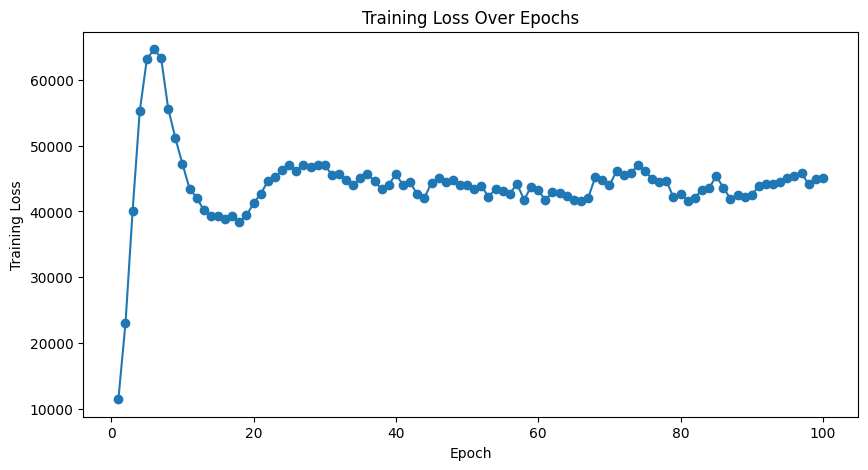

In [22]:
# Define the visualize_words_embedding function
def visualize_words_embedding(model, epoch, word2index):
    # Extract the embeddings from the model
    embeddings = model.embedding.weight.data.cpu().numpy()

    # Use TSNE to reduce the dimensionality of the embeddings
    tsne = TSNE(n_components=2, random_state=0)
    embeddings_2d = tsne.fit_transform(embeddings)

    # Create a dataframe for visualization
    df = pd.DataFrame(embeddings_2d, columns=['x', 'y'])
    df['word'] = [index2word[i] for i in range(len(embeddings_2d))]

    # Print the embeddings in a tabular format
    print(f'Word Embeddings Visualization - {epoch}')
    print(df.head(10))  # Print the first 10 rows for brevity

# Initialize the model instance
model = Skip_Gram_Model(len(vocabulary), embedding_size=embedding_size)

# Initialize the loss and optimizer functions
loss_function = nn.CrossEntropyLoss()  # Calculates the error rate between the predicted value and the original value
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # A stochastic gradient descent

# Visualize the word embeddings before training
visualize_words_embedding(model, "Before Training", word2index)

# List to store the training loss for each epoch
training_loss = []

# Start the training process
for epoch in range(epochs):
    total_loss = 0  # Restart loss to 0

    # Iterate over batch size
    for i in range(0, len(X_train), batch_size):
        x = X_train[i:i + batch_size]
        y_true = y_train[i:i + batch_size]
        optimizer.zero_grad()  # Clear the gradients
        y_pred = model(x)  # Forward pass
        loss = loss_function(y_pred, y_true.view(-1))
        loss.backward()  # Backward pass
        optimizer.step()  # Update model parameters
        total_loss += loss.item()

    # Append the total loss for this epoch to the list
    training_loss.append(total_loss)

    print(f'Epoch num: {epoch + 1}, loss value: {total_loss:.3f}')

    visualize_words_embedding(model, epoch, word2index)

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), training_loss, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Epochs')
plt.show()


In [23]:
def compute_similarity(word1, word2, model, word2index):
    # Get the embeddings for the words
    embedding1 = model.embedding.weight.data[word2index[word1]]
    embedding2 = model.embedding.weight.data[word2index[word2]]
    
    # Compute the dot product
    similarity = torch.dot(embedding1, embedding2).item()
    
    return similarity

# Test the embeddings by comparing word similarity
word_pairs = [('chatgpt', 'api'), ('model', 'reasoning'), ('newest', 'costefficient'), ('openai', 'developer')]
for word1, word2 in word_pairs:
    similarity = compute_similarity(word1, word2, model, word2index)
    print(f'Similarity between "{word1}" and "{word2}": {similarity:.4f}')

Similarity between "chatgpt" and "api": 61.9980
Similarity between "model" and "reasoning": 34.7957
Similarity between "newest" and "costefficient": 332.7480
Similarity between "openai" and "developer": 10.4324
